# Embedding 降维可视化

对 **item embedding（2560-d）** 做降维可视化，并按 **类别** 上色。

- 默认：**t-SNE**  
- 可选：PCA(50) → t-SNE（更快、更稳，想对比时打开开关即可）
- 额外：提供一个简单的 **kNN 类别纯度** 量化指标，辅助判断“类别是否可分”。


In [28]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

from collections import Counter

In [ ]:
# ====== 你只需要改这里 ======
from pathlib import Path

EMB_DIR = Path("./data/Amazon2018/All_Amazon")   # embedding 目录 / 文件

# 抽样设置：t-SNE 很慢，建议均衡抽样
USE_BALANCED_SAMPLE = True
PER_CAT = 3000          # 每个类别最多采样多少
SEED = 2024

# t-SNE 超参
PERPLEXITY = 100         # 样本越多可设越大
N_ITER = 2000
INIT = "random"         # 不用 PCA 时建议 random；用 PCA 时可设 "pca"

# 先 PCA 再 t-SNE
USE_PCA_BEFORE_TSNE = False
PCA_DIM = 50            # USE_PCA_BEFORE_TSNE=True 时生效

# 是否做 L2 归一化（强烈建议，等价于让欧式距离更接近 cosine）
L2_NORMALIZE = True

# 输出图片（可选）
SAVE_FIG = False
FIG_PATH = Path(f"./fig/embed_{PER_CAT}_tsne.png")


## 1) 读取 embedding，并自动生成类别标签

In [ ]:
def _load_npy_or_npz(f: Path) -> np.ndarray:
    obj = np.load(f, allow_pickle=False)
    if isinstance(obj, np.lib.npyio.NpzFile):
        keys = list(obj.files)
        arr = obj[keys[0]] if len(keys) == 1 else obj["arr_0"]
    else:
        arr = obj
    arr = np.asarray(arr)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    if arr.ndim != 2:
        raise ValueError(f"{f} must be 1D/2D, got {arr.shape}")
    if arr.dtype != np.float32:
        arr = arr.astype(np.float32, copy=False)
    # 清 NaN/Inf
    if np.isnan(arr).any() or np.isinf(arr).any():
        np.nan_to_num(arr, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    return arr

def load_embeddings_dir_with_splits(emb_path: Path):
    """如果 emb_path 是目录：读取其中所有 .npy/.npz 并按文件名排序 stack；
    如果是文件：只读这一个文件（类别会统一标记为文件 stem）。

    返回：X (N,D), y_cat (N,), splits(list[dict])
    """
    if emb_path.is_file():
        arr = _load_npy_or_npz(emb_path)
        cat = emb_path.stem
        X = arr
        y = np.array([cat] * len(X))
        splits = [{"file": emb_path.name, "cat": cat, "start": 0, "end": len(X)-1, "n": len(X)}]
        print(f"[Emb] Loaded file: {emb_path} -> shape={X.shape}, cat={cat}")
        return X, y, splits

    if not emb_path.is_dir():
        raise FileNotFoundError(f"Not found: {emb_path}")

    files = sorted(list(emb_path.glob("*.npy")) + list(emb_path.glob("*.npz")))
    if not files:
        raise FileNotFoundError(f"No .npy/.npz files in: {emb_path}")

    arrays = []
    y = []
    splits = []
    start = 0
    dim = None

    print(f"[Emb] Loading directory: {emb_path} (files={len(files)})")
    for f in files:
        arr = _load_npy_or_npz(f)
        if dim is None:
            dim = arr.shape[1]
        elif arr.shape[1] != dim:
            raise ValueError(f"Dim mismatch: expected {dim}, got {arr.shape[1]} in {f.name}")

        n = arr.shape[0]
        end = start + n - 1

        # 类别名：取 `.emb-` 前的部分；否则用 stem
        name = f.name
        cat = name.split(".emb-")[0] if ".emb-" in name else f.stem

        print(f"[Emb] rows {start} ~ {end}: {f.name} (n={n}, dim={arr.shape[1]})  ->  cat={cat}")
        arrays.append(arr)
        y.extend([cat] * n)
        splits.append({"file": f.name, "cat": cat, "start": start, "end": end, "n": n})
        start = end + 1

    X = np.concatenate(arrays, axis=0)
    y = np.asarray(y)
    print(f"[Emb] Loaded embeddings shape: {X.shape}")
    return X, y, splits

X, y_cat, splits = load_embeddings_dir_with_splits(EMB_DIR)
N, D = X.shape
print("\n[Summary] N=", N, "D=", D)
print("[Summary] category counts:")
print(Counter(y_cat.tolist()))


[Emb] Loading directory: data/Amazon2018/All_Amazon (files=4)
[Emb] rows 0 ~ 8093: Arts_Crafts_and_Sewing.emb-Qwen3-Embedding-4B-td.npy (n=8094, dim=2560)  ->  cat=Arts_Crafts_and_Sewing
[Emb] rows 8094 ~ 11526: Industrial_and_Scientific.emb-Qwen3-Embedding-4B-td.npy (n=3433, dim=2560)  ->  cat=Industrial_and_Scientific
[Emb] rows 11527 ~ 19595: Office_Products.emb-Qwen3-Embedding-4B-td.npy (n=8069, dim=2560)  ->  cat=Office_Products
[Emb] rows 19596 ~ 22740: Video_Games.emb-Qwen3-Embedding-4B-td.npy (n=3145, dim=2560)  ->  cat=Video_Games
[Emb] Loaded embeddings shape: (22741, 2560)

[Summary] N= 22741 D= 2560
[Summary] category counts:
Counter({'Arts_Crafts_and_Sewing': 8094, 'Office_Products': 8069, 'Industrial_and_Scientific': 3433, 'Video_Games': 3145})


## 2) 预处理：L2 归一化（推荐） + 均衡抽样（推荐）

In [31]:
def l2_normalize(X: np.ndarray) -> np.ndarray:
    denom = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    return X / denom

def balanced_sample_indices(y: np.ndarray, per_cat: int, seed: int = 2024) -> np.ndarray:
    rng = np.random.default_rng(seed)
    idx_list = []
    for cat in np.unique(y):
        ids = np.where(y == cat)[0]
        take = min(per_cat, len(ids))
        idx_list.append(rng.choice(ids, size=take, replace=False))
    idx = np.concatenate(idx_list)
    rng.shuffle(idx)
    return idx

X_proc = X
if L2_NORMALIZE:
    X_proc = l2_normalize(X_proc.astype(np.float32, copy=False))
    print("[Pre] L2-normalized embeddings")

idx = np.arange(len(y_cat))
if USE_BALANCED_SAMPLE:
    idx = balanced_sample_indices(y_cat, per_cat=PER_CAT, seed=SEED)
    print(f"[Sample] balanced sample enabled: total={len(idx)} (per_cat<={PER_CAT})")
else:
    print(f"[Sample] using full data: total={len(idx)}")

X_vis = X_proc[idx]
y_vis = y_cat[idx]
print("[Sample] category counts:", Counter(y_vis.tolist()))


[Pre] L2-normalized embeddings
[Sample] balanced sample enabled: total=12000 (per_cat<=3000)
[Sample] category counts: Counter({'Office_Products': 3000, 'Video_Games': 3000, 'Arts_Crafts_and_Sewing': 3000, 'Industrial_and_Scientific': 3000})


## 3) t-SNE：直接跑（可选先 PCA 再跑）

In [32]:
# 可选：先 PCA 再 t-SNE（更快、更稳；你不想用就保持 False）
X_in = X_vis
if USE_PCA_BEFORE_TSNE:
    pca = PCA(n_components=PCA_DIM, random_state=SEED)
    X_in = pca.fit_transform(X_vis)
    print("[PCA] enabled: dim", PCA_DIM, "explained_var_sum=", float(pca.explained_variance_ratio_.sum()))
else:
    print("[PCA] disabled")

tsne = TSNE(
    n_components=2,
    perplexity=PERPLEXITY,
    max_iter=N_ITER,
    init=INIT,
    learning_rate="auto",
    random_state=SEED,
    verbose=1
)

Z = tsne.fit_transform(X_in)
Z.shape


[PCA] disabled
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.011s...
[t-SNE] Computed neighbors for 12000 samples in 2.461s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.219353
[t-SN

(12000, 2)

## 4) 画图：按类别上色 + centroid 标注 + 图例

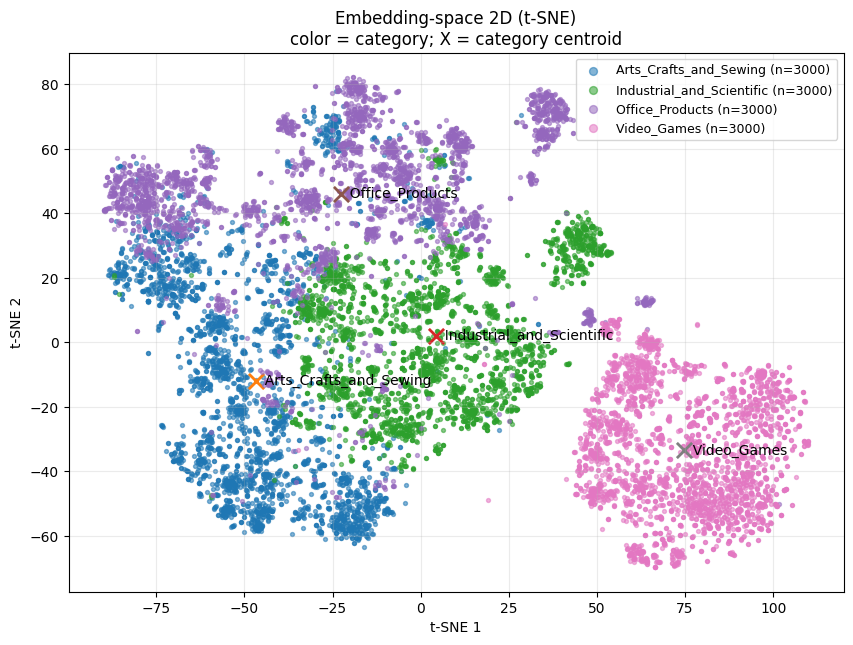

In [33]:
le = LabelEncoder()
y_id = le.fit_transform(y_vis)

plt.figure(figsize=(10, 7))
for i, cat in enumerate(le.classes_):
    m = (y_id == i)
    pts = Z[m]
    plt.scatter(pts[:, 0], pts[:, 1], s=8, alpha=0.55, label=f"{cat} (n={m.sum()})")

    # 类别质心 + 标注
    cx, cy = pts[:, 0].mean(), pts[:, 1].mean()
    plt.scatter([cx], [cy], marker="x", s=120, linewidths=2)
    plt.text(cx, cy, f"  {cat}", fontsize=10, va="center")

plt.title("Embedding-space 2D (t-SNE)\ncolor = category; X = category centroid")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True, alpha=0.25)
plt.legend(loc="best", fontsize=9, markerscale=2)

if SAVE_FIG:
    plt.savefig(FIG_PATH, dpi=200, bbox_inches="tight")
    print("Saved figure to:", FIG_PATH.resolve())

plt.show()

## 5) 量化：kNN 类别纯度（在原 embedding 空间）

In [34]:
# 说明：这一步在 embedding 空间计算（用 X_vis），不依赖 t-SNE 的投影。
# cosine 距离：如果你做了 L2_NORMALIZE=True，则 cosine 与欧式单调等价；这里直接用 cosine。
nn = NearestNeighbors(n_neighbors=51, metric="cosine", n_jobs=-1)
nn.fit(X_vis)

dist, nbr_idx = nn.kneighbors(X_vis, return_distance=True)
nbr = nbr_idx[:, 1:]  # 去掉自己

def knn_purity(k: int) -> float:
    same = (y_id[nbr[:, :k]] == y_id[:, None]).mean(axis=1)
    return float(same.mean())

for k in [5, 10, 20, 50]:
    print(f"k={k:>2}, mean kNN category purity = {knn_purity(k):.4f}")


k= 5, mean kNN category purity = 0.9441
k=10, mean kNN category purity = 0.9353
k=20, mean kNN category purity = 0.9220
k=50, mean kNN category purity = 0.8933
